In [1]:
from sklearn.model_selection import train_test_split
import random
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms

In [2]:
training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [3]:
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [4]:
# Extract features and labels
X, y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Normalize images (Convert to range [0,1])
X = X / 255.0
X_test = X_test / 255.0

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess Images

In [5]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(0, shear=15, scale=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

X_train_torch = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_val_torch = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_torch = torch.tensor(y_val, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
val_data = TensorDataset(X_val_torch, y_val_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

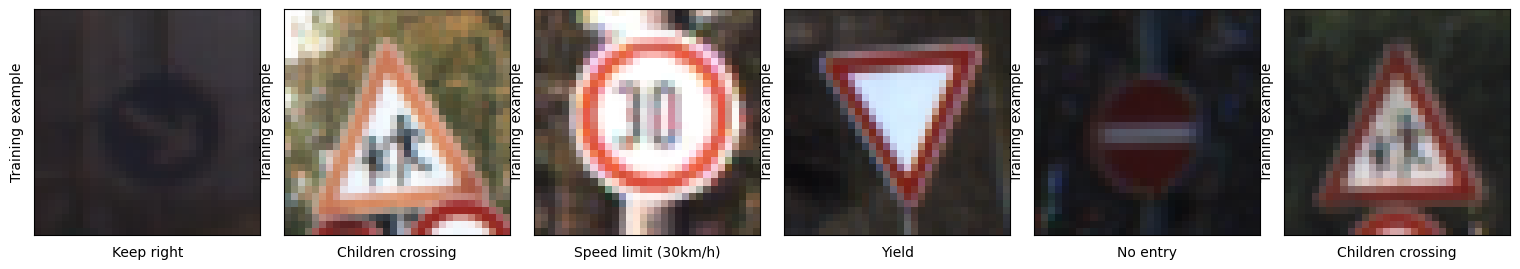

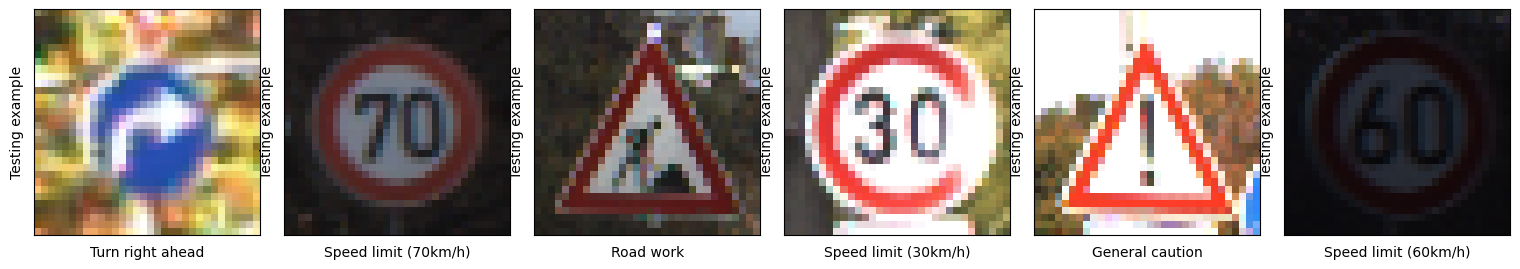

In [6]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")

In [7]:
def plot_loss_accuracy(trainLoss, valLoss, trainAcc, valAcc):
    """ Plot loss and accuracy curves."""
    fig, ax = plt.subplots(1,2,figsize=(16,5))
    ax[0].plot(trainLoss,'s-',label='Train Loss')
    ax[0].plot(valLoss,'o-',label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Model Loss')
    ax[0].legend()
    
    ax[1].plot(trainAcc,'s-',label='Train Accuracy')
    ax[1].plot(valAcc,'o-',label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title('Model Accuracy')
    ax[1].legend()
    plt.show()

In [8]:
def evaluate_model(model, test_loader, device):
    """ Evaluate the model on the test set and return accuracy."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            predictions = torch.argmax(y_hat, dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [9]:
def visualize_predictions(model, test_loader, signs, device, num_images=6):
    """ Display some predictions along with true labels."""
    model.eval()
    X_batch, y_batch = next(iter(test_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    with torch.no_grad():
        y_hat = model(X_batch)
        predictions = torch.argmax(y_hat, dim=1)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 16))
    for i in range(num_images):
        img = X_batch[i].permute(1,2,0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].set_title(f'True: {signs[y_batch[i].item()]}, Pred: {signs[predictions[i].item()]}')
        axes[i].axis('off')
    plt.show()

In [10]:
NUM_CLASSES = len(np.unique(y_train))
EPOCHS = 20

# LeNet-5 Model

In [11]:
def makeLeNet5(nclasses=43):
    class LeNet5(nn.Module):
        def __init__(self):
            super(LeNet5, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, 100, kernel_size=5), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(100, 150, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(150, 250, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2)
            )
            self.fc_layers = nn.Sequential(
                nn.Linear(250 * 2 * 2, 350), nn.ReLU(), nn.Dropout(0.7),
                nn.Linear(350, nclasses)
            )
        def forward(self, x):
            x = self.conv_layers(x)
            x = torch.flatten(x, 1)
            x = self.fc_layers(x)
            return F.log_softmax(x, dim=1)
    net = LeNet5()
    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
    return net, lossfun, optimizer

In [12]:
def trainModel(net, lossfun, optimizer, train_loader, val_loader, test_loader, EPOCHS=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    # Track losses and accuracy
    trainLoss = torch.zeros(EPOCHS)
    valLoss  = torch.zeros(EPOCHS)
    trainAcc  = torch.zeros(EPOCHS)
    valAcc    = torch.zeros(EPOCHS)

    best_val_acc = 0
    patience = 2
    epochs_no_improve = 0

    for epoch in range(EPOCHS):
        net.train()
        batch_loss = []
        batch_acc = []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = lossfun(y_hat, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            predictions = torch.argmax(y_hat, dim=1)
            batch_acc.append((predictions == y).float().mean().item())

        trainLoss[epoch] = np.mean(batch_loss)
        trainAcc[epoch] = 100 * np.mean(batch_acc)

        # Validation Evaluation
        net.eval()
        val_loss, val_correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += lossfun(y_hat, y).item()
                val_correct += (torch.argmax(y_hat, dim=1) == y).sum().item()
                total += y.size(0)

        valLoss[epoch] = val_loss / len(val_loader)
        valAcc[epoch] = 100 * (val_correct / total)

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {trainLoss[epoch]:.4f}, Val Loss: {valLoss[epoch]:.4f}, Train Acc: {trainAcc[epoch]:.2f}%, Val Acc: {valAcc[epoch]:.2f}%")

        scheduler.step()
        if valAcc[epoch] > best_val_acc:
            best_val_acc = valAcc[epoch]
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    return trainLoss, valLoss, trainAcc, valAcc, net, device

In [ ]:
net, lossfun, optimizer = makeLeNet5()
trainLoss, valLoss, trainAcc, valAcc, trained_model, device = trainModel(net, lossfun, optimizer, train_loader, val_loader, test_loader, EPOCHS=20)

Epoch 1/20 - Train Loss: 3.1187, Val Loss: 2.3164, Train Acc: 15.79%, Val Acc: 34.74%


In [ ]:
plot_loss_accuracy(trainLoss, valLoss, trainAcc, valAcc)
evaluate_model(trained_model, test_loader, device)
visualize_predictions(trained_model, test_loader, signs, device)

# VGGNet Model

In [ ]:
def makeVGGNet():
    class VGGNet(nn.Module):
        def __init__(self, nclasses=43):
            super(VGGNet, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )
            self.fc_layers = nn.Sequential(
                nn.Linear(256 * 4 * 4, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, nclasses)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = torch.flatten(x, 1)
            x = self.fc_layers(x)
            return F.log_softmax(x, dim=1)

    net = VGGNet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
    return net, lossfun, optimizer

In [ ]:
net, lossfun, optimizer = makeVGGNet()
trainLoss, valLoss, trainAcc, valAcc, trained_model, device = trainModel(net, lossfun, optimizer, train_loader, val_loader, test_loader, EPOCHS=20)

In [ ]:
plot_loss_accuracy(trainLoss, valLoss, trainAcc, valAcc)
evaluate_model(trained_model, test_loader, device)
visualize_predictions(trained_model, test_loader, signs, device)